In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(data.table)
options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
#install.packages('cowplot')

In [3]:
results = read.csv(file = '../outputs/results/merged_capacity_results.csv')

# remove gas storage
results[results$node == "israel_gas_storage", "node"] <- "israel_natural_gas"
results[results$technology == "Gas Reservoir", "technology"] <- "Gas"

# change ccgt category
results[results$node == "west_bank_ccgt", "node"] <- "west_bank_natural_gas"
results[results$node == "jordan_ccgt", "node"] <- "jordan_natural_gas"
results[results$node == "israel_ccgt", "node"] <- "israel_natural_gas"

# get caps by scenario
capacity_by_scenario = results %>% group_by(node,scenario) %>% summarise_all(list(max),na.rm=TRUE)

# add colours 
tech = c("Battery","Diesel","Gas","Solar","Coal","Wind","Shale")
cols = c("lightskyblue","lightcoral","lightgray","lightgoldenrod1","black","mediumaquamarine","mistyrose3")
colour_df = data.frame(row.names=tech,val=cols)

# add colour codes
unique_technologies = unique(capacity_by_scenario$technology)
count = 1
for (val in unique_technologies) {
    capacity_by_scenario[capacity_by_scenario$technology == val, "colours"] <- colour_df[val,]
    count = count + 1
}

In [4]:
head(capacity_by_scenario, n = 3)

node,scenario,commodity,timestep,value,technology,territory,colours
<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>
gaza_battery_storage,BAS,electricity,8760,0.000,Battery,Gaza,lightskyblue
gaza_battery_storage,BAU,electricity,8760,948.855,Battery,Gaza,lightskyblue
gaza_battery_storage,COO,electricity,8760,0.000,Battery,Gaza,lightskyblue


In [5]:
oms_waterfall <- function(capacity_by_scenario,scenario_to_filter) {
    
    # ************************************************************************* ----
    # Params ----
    # ************************************************************************* ----
    
    ylim_max =             65
    axis_steps =           10
    top_label_distance =   ylim_max * 0.04
    box_label_threshold =  5
    label_decimals =       1
    
    # define colours
    plotting_colours = c(
                        # Gas
                        '#85929e',
                        # Solar
                        '#f4d03f',
                        # Shale
                        '#82e0aa',
                        # Diesel,
                        '#bb8fce',
                        # Coal
                        '#566573',
                        # Battery
                        '#f1948a',
                        # Wind
                        '#5dade2'
                        )

    regions_to_plot = c("Gaza", "West Bank", "Jordan", "Israel")
    technologies_to_plot = c("Gas", "Solar", "Shale", "Diesel", "Coal", "Battery", "Wind")
    
    # ************************************************************************* ----
    # Original data ----
    # ************************************************************************* ----

    # df <- 
    #   data.frame(
    #     x.axis.Var = rep(c("GZA", "WBK", "JOR", "ISR"), 4),
    #     cat.Var = rep(c("Wind", "Solar", "Battery" , "Gas"), each = 4),
    #     values = c(40.9, 500, 300, 200, # Wind
    #                300, 200, 300, 250, # Solar
    #                50, 50, 50, 50, # Battery
    #                100, 80, 200, 150   # Gas (BASE VALUE: IMPORTANT!)
    #                )
    #   )


    # select specific columns
    scenario_results = capacity_by_scenario

    # filter results by scenario
    scenario_results = filter(scenario_results, scenario == scenario_to_filter) # , value > 0

    df <- 
      data.frame(
        x.axis.Var = rep(regions_to_plot, length(technologies_to_plot)),
        cat.Var = rep(technologies_to_plot, each = 4)
      )

    df$values = -999

    for(i in 1:nrow(df)) {       # for-loop over rows
      tmp_df = filter(scenario_results, technology == df[i,]$cat.Var, territory == df[i,]$x.axis.Var)

      if (dim(tmp_df)[1] == 0) {
        df[i,]$values = 0
      } else {
        df[i,]$values = round(tmp_df$value/1000,label_decimals) # convert to GW
      }
    }
    
    # ************************************************************************* ----
    # Data for Waterfall Chart ----
    # ************************************************************************* ----

    df.tmp <- df %>%
      # \_Set the factor levels in the order you want ----
      mutate(
        x.axis.Var = factor(x.axis.Var,
                            levels = regions_to_plot),
        cat.Var = factor(cat.Var,
                            levels = technologies_to_plot)
      ) %>%
      # \_Sort by Group and Category ----
      arrange(x.axis.Var, desc(cat.Var)) %>%
      # \_Get the start and end points of the bars ----
      mutate(end.Bar = cumsum(values),
             start.Bar = c(0, head(end.Bar, -1))) %>%
      # \_Add a new Group called 'Total' with total by category ----
      rbind(
        df %>%
          # \___Sum by Categories ----
          group_by(cat.Var) %>% 
          summarise(values = sum(values)) %>%
          # \___Create new Group: 'Total' ----
          mutate(
            x.axis.Var = "Total",
            cat.Var = factor(cat.Var,
                             levels = technologies_to_plot)
          ) %>%
          # \___Sort by Group and Category ----
          arrange(x.axis.Var, desc(cat.Var)) %>%
          # \___Get the start and end points of the bars ----
          mutate(end.Bar = cumsum(values),
                 start.Bar = c(0, head(end.Bar, -1))) %>%
          # \___Put variables in the same order ----
          select(names(df),end.Bar,start.Bar)
      ) %>%
      # \_Get numeric index for the groups ----
      mutate(group.id = group_indices(., x.axis.Var)) %>%
      # \_Create new variable with total by group ----
      group_by(x.axis.Var) %>%
      mutate(total.by.x = sum(values)) %>%
      # \_Order the columns ----
      select(x.axis.Var, cat.Var, group.id, start.Bar, values, end.Bar, total.by.x)

    # ************************************************************************* ----
    # Plot ----
    # ************************************************************************* ----

    ggplot(df.tmp, aes(x = group.id, fill = cat.Var)) + 
      # \_Simple Waterfall Chart ----
      geom_rect(aes(x = group.id,
                    xmin = group.id - 0.25, # control bar gap width
                    xmax = group.id + 0.25, 
                    ymin = end.Bar,
                    ymax = start.Bar),
                color="black", 
                alpha=0.95) + 
      # \_Lines Between Bars ----
      geom_segment(aes(x=ifelse(group.id == last(group.id),
                                last(group.id),
                                group.id+0.25), 
                       xend=ifelse(group.id == last(group.id),
                                   last(group.id),
                                   group.id+0.75), 
                       y=ifelse(cat.Var == "Gas",
                                end.Bar,
                                # these will be removed once we set the y limits
                                max(end.Bar)*2), 
                       yend=ifelse(cat.Var == "Gas",
                                   end.Bar,
                                   # these will be removed once we set the y limits
                                   max(end.Bar)*2)), 
                   colour="black") +
      # \_Numbers inside bars (each category) ----
      geom_text(
        mapping = 
          aes(
            label = ifelse(values < box_label_threshold, 
                           "",
                           ifelse(nchar(values) == 3,
                                  as.character(values),
                                  as.character(values)
                                  )
                           ),
            y = rowSums(cbind(start.Bar,values/2))
            ),
        color = "black",
        fontface = "bold"
        ) + 
      # \_Total for each category above bars ----
      geom_text(
        mapping = 
          aes(
            label = ifelse(cat.Var != "Gas", 
                           "",
                           ifelse(nchar(total.by.x) == 3,
                                  as.character(total.by.x),
                                  as.character(total.by.x)
                                )
                          ),
            y = end.Bar + top_label_distance
          ),
        color = "black",
        fontface = "bold"
      ) + 
      # \_Change colors ----
      scale_fill_manual(values=plotting_colours) +
      # \_Change y axis to same scale as original ----
      scale_y_continuous(
        expand=c(0,0),
        limits = c(0, ylim_max),
        breaks = seq(0, ylim_max, axis_steps),
        labels = ifelse(nchar(seq(0, ylim_max, axis_steps)) < 4,
                        as.character(seq(0, ylim_max, axis_steps)),
                        seq(0, ylim_max, axis_steps)
                        )
      ) +
      # \_Add tick marks on x axis to look like the original plot ----
      scale_x_continuous(
        expand=c(0,0),
        limits = c(min(df.tmp$group.id)-0.5,max(df.tmp$group.id)+0.5),
        breaks = c(min(df.tmp$group.id)-0.5,
                   unique(df.tmp$group.id), 
                   unique(df.tmp$group.id) + 0.5
                   ),
        labels = 
          c("", 
            as.character(unique(df.tmp$x.axis.Var)), 
            rep(c(""), length(unique(df.tmp$x.axis.Var)))
          )
      ) +
      labs(
        #title = scenario_to_filter,
        subtitle = scenario_to_filter,
        y = 'Installed capacity (GW)',
      ) +
      # \_Theme options to make it look like the original plot ----
      theme(
        text = element_text(size = 14, color = "black"),
        axis.text = element_text(size = 10, color = "black", face = "bold"),
        axis.text.y = element_text(margin = margin(r = 0.3, unit = "cm")),
        axis.ticks.x =
          element_line(color =
                         c("black",
                           rep(NA, length(unique(df.tmp$x.axis.Var))),
                           rep("black", length(unique(df.tmp$x.axis.Var))-1)
                         )
                       ),
        axis.line = element_line(colour = "black", size = 0.5),
        axis.ticks.length = unit(.15, "cm"),
        axis.title.x =       element_blank(),
        #axis.title.y =       element_blank(),
        panel.background =   element_blank(),
        #plot.margin =        unit(c(1, 1, 1, 1), "lines"),
        legend.text =        element_text(size = 10, 
                                          color = "black",
                                          face = "bold",
                                          margin = margin(l = 0.25, unit = "cm")
                                          ),
        legend.title =       element_blank()
      )
  #return(temp_C)
}

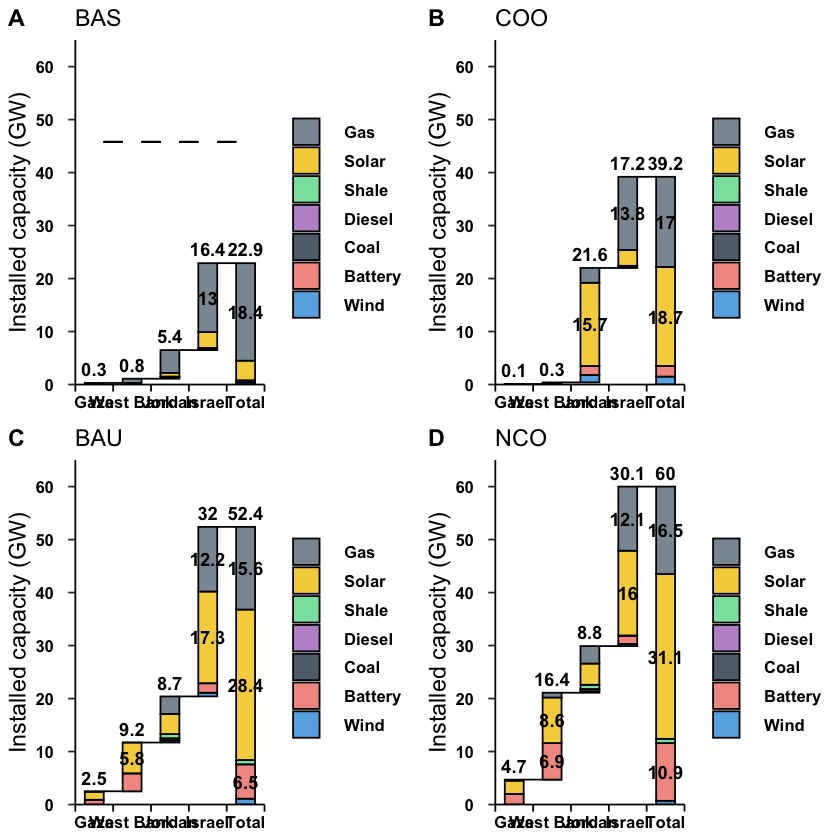

In [6]:
p1 = oms_waterfall(capacity_by_scenario,scenario_to_filter='BAS')
p2 = oms_waterfall(capacity_by_scenario,scenario_to_filter='COO')
p3 = oms_waterfall(capacity_by_scenario,scenario_to_filter='BAU')
p4 = oms_waterfall(capacity_by_scenario,scenario_to_filter='NCO')

plot_grid(p1, p2, p3, p4, labels = "AUTO", nrow = 2, ncol = 2) #plot3,
ggsave("../outputs/figures/oms_waterfall.png", width = 30, height = 20, units = "cm")